<a href="https://colab.research.google.com/github/YMoule/MAT-128-Project/blob/main/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
files = {
    "Amazon": r"AMAZON_daily.csv",
    "Apple": r"APPLE_daily.csv",
    "Google": r"GOOGLE_daily.csv",
    "Meta": r"META_daily.csv",
    "Netflix": r"NETFLIX_daily.csv"
}


data = {}
for company, file in files.items():
    data[company] = pd.read_csv(file)
    data[company] = data[company][['Date','Close']]





# 添加滞后特征
X=np.empty((0, 14))
y=np.empty((0,1))
companies = ['Amazon', 'Apple','Google','Meta','Netflix']
for j, company in enumerate(companies):
  data[company]['Date'] = pd.to_datetime(data[company]['Date'])
  # 移除2013年前的数据
  data[company] = data[company][data[company]['Date'].dt.year >= 2013]
  for i in range(1, 8):  # 添加前7天的收盘价作为特征
    data[company][[f'lag_{i}']] = data[company][['Close']].shift(i)

# 移除包含NaN的行
  data[company] = data[company].dropna()

  data[company]=np.hstack((data[company], np.zeros((len(data[company]), j))))
  data[company]=np.hstack((data[company], np.ones((len(data[company]), 1))))
  data[company]=np.hstack((data[company], np.zeros((len(data[company]), 4-j))))

# 划分特征和目标变量
  X = np.vstack((X,data[company]))
  y= np.vstack((y,data[company][:,1].reshape(-1,1)))

y= np.array(y)
scalery = MinMaxScaler()
y = scalery.fit_transform(y)
X=np.array(X)
X=np.delete(X,1,axis=1)
scalerx = MinMaxScaler()
X[:,1:] = scalerx.fit_transform(X[:,1:])
print(X.shape)
print(y.shape)
print(X)
print(y)

# 训练模型并预测
def train_and_predict(X, y, test_size=0.2):

    cutoff_date = np.quantile(X[:,0], 1-test_size)
    test_ind = X[:,0]>= cutoff_date
    train_ind = X[:,0] < cutoff_date

    X=np.delete(X,0,axis=1)

    X_train = X[train_ind]
    X_test = X[test_ind]
    y_train = y[train_ind]
    y_test = y[test_ind]

    # 划分训练集和测试集
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(model.coef_)

    # 预测
    y_pred = model.predict(X_test)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    company = X_test[:,-5:]



    return {
        'model': model,
        'predictions': y_pred,
        'actual_prices': y_test,
        'company': company,
        'metrics': {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    }

# 预测未来两个月的价格
def predict_future(model, last_data, start_date, end_date):
    # 生成未来日期
    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')

    # 初始化预测结果列表
    future_predictions = []

    # 获取最后可用数据
    #last_row = last_data.iloc[-1].copy()
    features = last_data

    for date in future_dates:

        # 预测
        prediction = model.predict(features)[0]

        temp = np.concatenate((features[0][1:7],prediction))
        features = np.concatenate((temp,features[0][7:])).reshape(1,-1)
        # 保存预测结果
        future_predictions.append({
            'date': date,
            'prediction': prediction
        })

    return pd.DataFrame(future_predictions)

# 可视化结果
def visualize_results(company, actual_results, train_results, metrics):
    plt.figure(figsize=(14, 7))


    # 绘制训练数据
    plt.plot(train_results,
             label='real price', color='blue')

    # 绘制测试数据预测结果
    plt.plot(actual_results,
             label='prediction price', color='red', linestyle='--')

    # 绘制未来预测
    plt.title(f'{company} Stock price prediction')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 显示评估指标
    plt.figtext(0.15, 0.01,
                f"MSE: {metrics['MSE']:.2f} | RMSE: {metrics['RMSE']:.2f} | "
                f"MAE: {metrics['MAE']:.2f} | R²: {metrics['R²']:.2f}",
                ha="left", fontsize=9, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.show()



(15485, 13)
(15485, 1)
[[Timestamp('2013-01-11 00:00:00') 0.001171693087247929
  0.001240769560766613 ... 0.0 0.0 0.0]
 [Timestamp('2013-01-14 00:00:00') 0.0012852735443430637
  0.0011957424304669811 ... 0.0 0.0 0.0]
 [Timestamp('2013-01-15 00:00:00') 0.0014945235607723394
  0.0013116541596549427 ... 0.0 0.0 0.0]
 ...
 [Timestamp('2025-05-01 00:00:00') 0.9783585556918776 0.9930185924783868
  ... 0.0 0.0 1.0]
 [Timestamp('2025-05-02 00:00:00') 0.979887522089802 0.998439651119688
  ... 0.0 0.0 1.0]
 [Timestamp('2025-05-05 00:00:00') 1.0 1.0 ... 0.0 0.0 1.0]]
[[0.00128527]
 [0.00149452]
 [0.00145827]
 ...
 [0.97988752]
 [1.        ]
 [0.98040308]]


[[ 9.55849638e-01  6.34928718e-02 -2.45875387e-02  1.88303710e-02
  -5.87288590e-02  6.21658973e-03  3.65440130e-02 -6.35880300e-05
  -6.19866067e-05 -8.30744600e-05  2.42057500e-05  1.84443347e-04]]


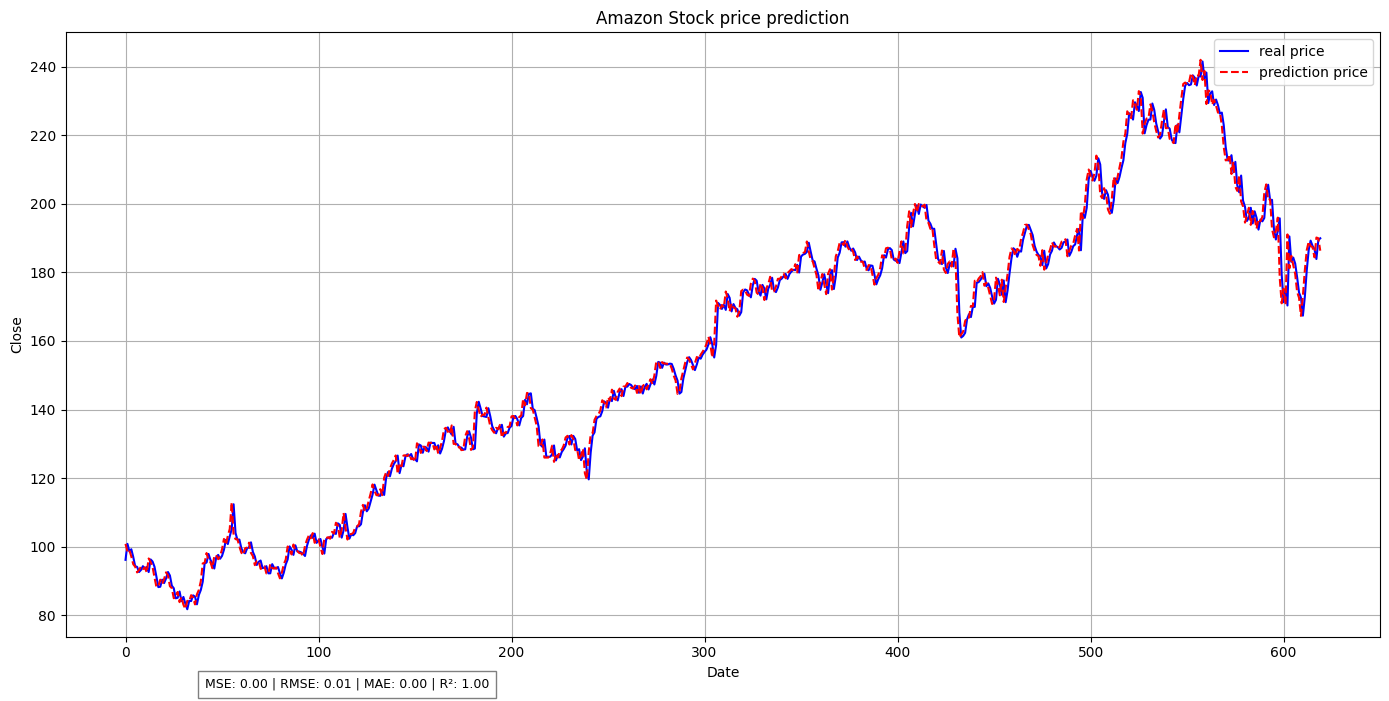

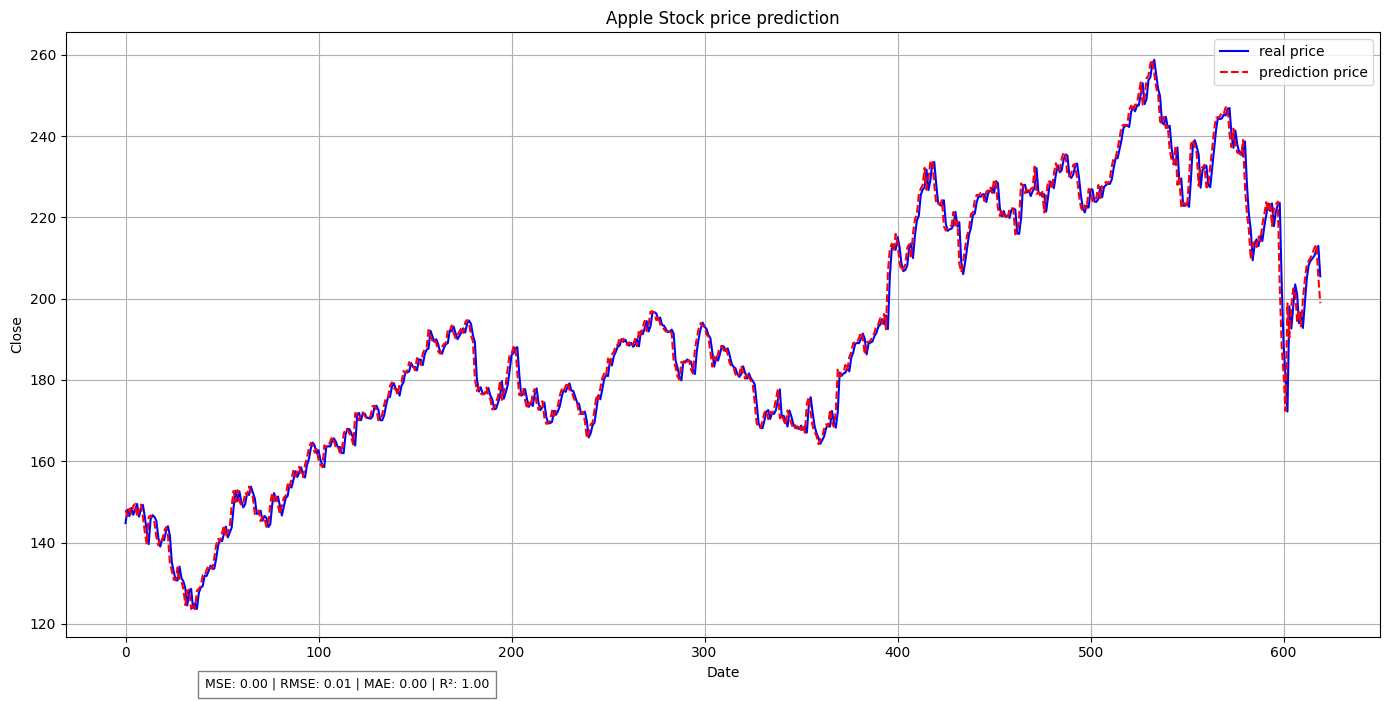

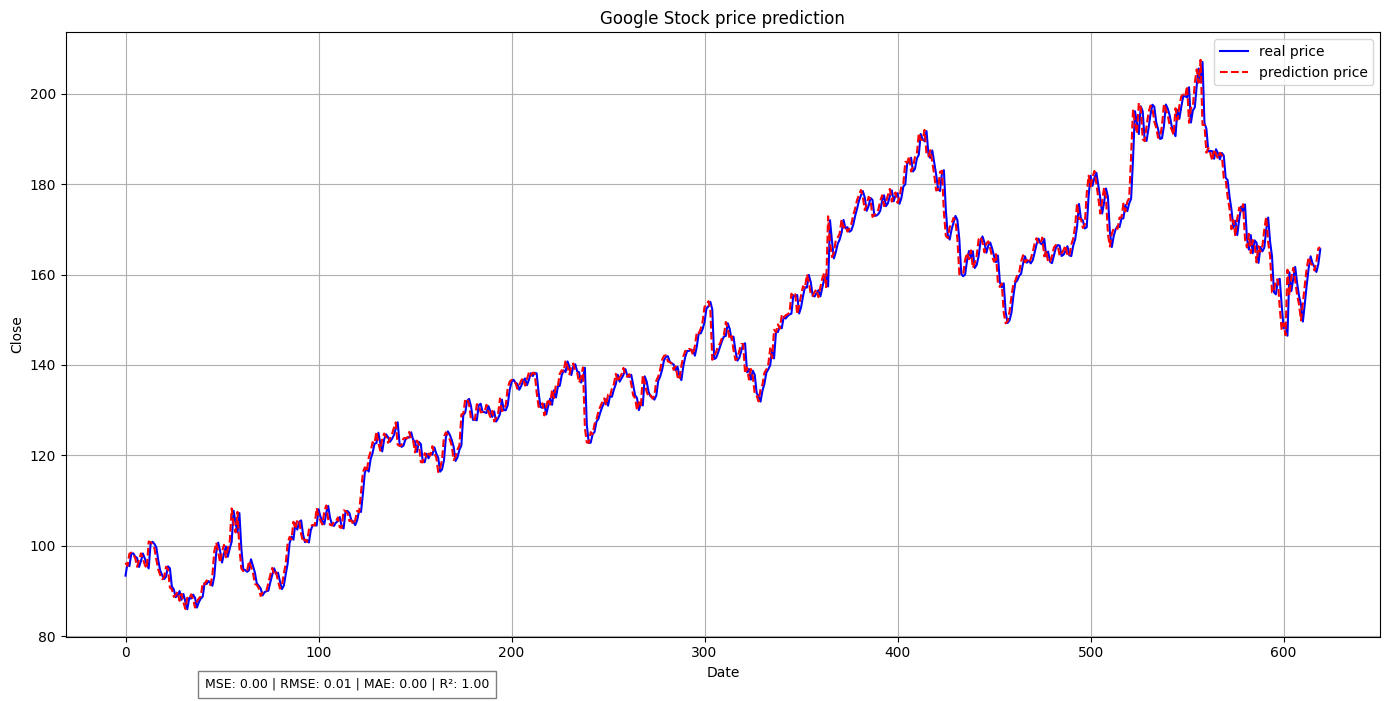

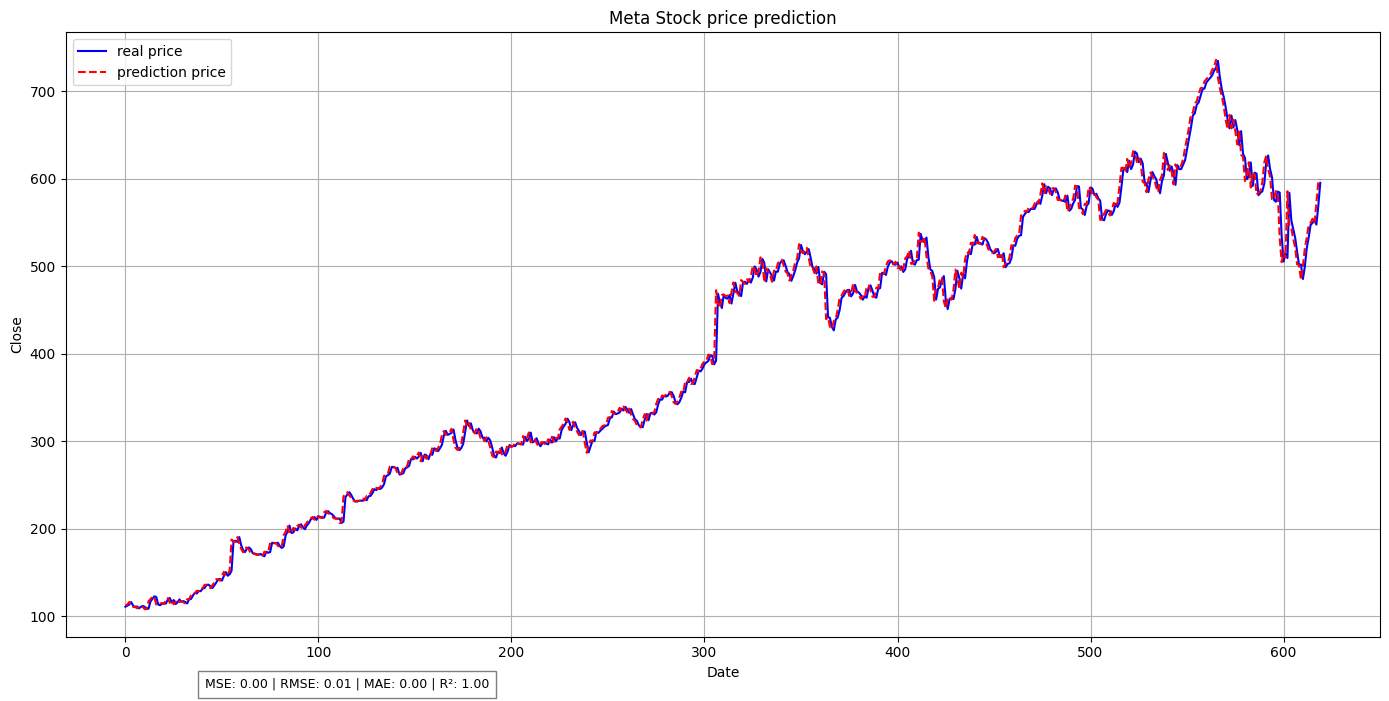

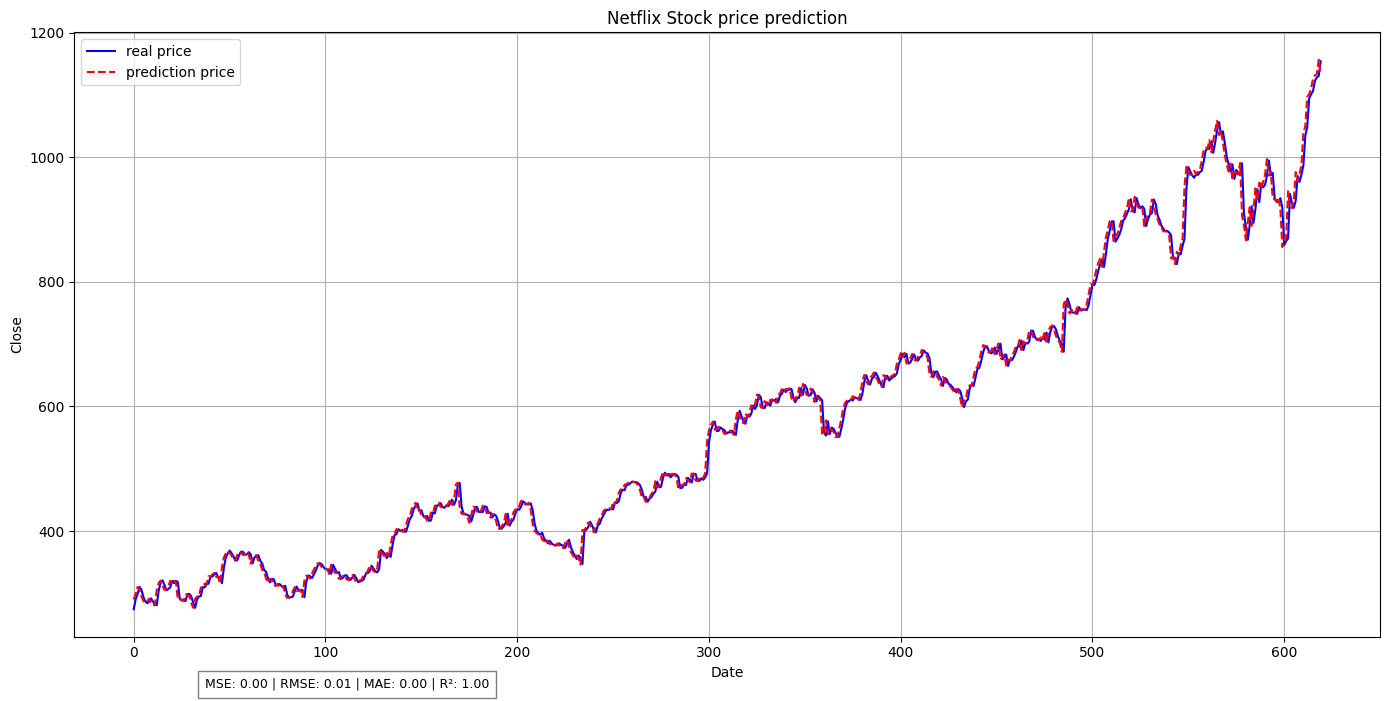

{'model': LinearRegression(),
 'predictions': array([[0.07356978],
        [0.07765142],
        [0.07575432],
        ...,
        [0.97541774],
        [0.97737014],
        [0.99796417]]),
 'actual_prices': array([[0.07764011],
        [0.07563061],
        [0.07602377],
        ...,
        [0.97988752],
        [1.        ],
        [0.98040308]]),
 'company': array([[1.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0]], dtype=object),
 'metrics': {'MSE': 4.834156138813883e-05,
  'RMSE': np.float64(0.006952809603903938),
  'MAE': 0.0038590882602448765,
  'R²': 0.998584869145701}}

In [3]:
dictionary =train_and_predict(X, y, test_size=0.2)
train_results = dictionary['predictions']
train_results = scalery.inverse_transform(train_results)
actual_results = dictionary['actual_prices']
actual_results = scalery.inverse_transform(actual_results)
companies = dictionary['company']
company_name = ['Amazon', 'Apple','Google','Meta','Netflix']
metrics = dictionary['metrics']

for i, company in enumerate(company_name):
  ind = companies[:,i]==1
  visualize_results(company, actual_results[ind], train_results[ind],metrics, future_predictions=None)

dictionary


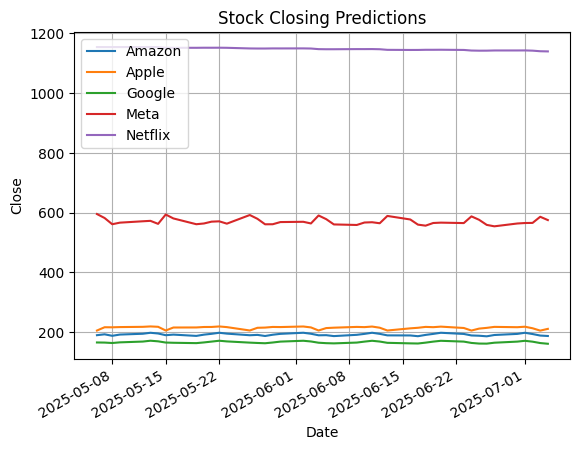

In [61]:
model = dictionary['model']
start_date = np.datetime64('2025-05-06 00:00:00')
end_date = np.datetime64('2025-07-06 00:00:00')
companies = ['Amazon', 'Apple','Google','Meta','Netflix']
dict={}
for company in companies:
  last_data = data[company][-1,2:].reshape(1,-1)
  last_data = scalerx.transform(last_data)
  var =predict_future(model, last_data, start_date, end_date)
  preds = scalery.inverse_transform(var['prediction'].to_numpy().reshape(-1,1))
  dict[company+'preds'] = preds
  dict[company+'date'] = var['date']

  plt.plot(var['date'], preds, label = company)
plt.title('Stock Closing Predictions')
plt.legend()
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.show()